In [1]:
import os
from skimage import io
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  


def obtain_data(filename):
    path_images = "/home/nicolas/Nicolas/MineriaDatos/Dogs/"

    path_class_1 = path_images + filename
    filenames_class_1 = os.listdir(path_class_1)
    
    train_class_1 = []
    for i in filenames_class_1:
        filename = os.path.join(path_class_1 + "/" + i)
        camera = io.imread(filename)
        train_class_1.append(camera)
    train_class_1 = np.asarray(train_class_1)
    train_class_1 = np.reshape(train_class_1,(len(train_class_1), train_class_1.shape[1]*train_class_1.shape[2]*train_class_1.shape[3]))
    return train_class_1

In [2]:
filenames_dogs = os.listdir("/home/nicolas/Nicolas/MineriaDatos/Dogs/")

In [3]:
train_dogs = np.vstack((obtain_data(filenames_dogs[0]),obtain_data(filenames_dogs[1]),obtain_data(filenames_dogs[2])))

In [4]:
train_dogs.shape

(524, 58800)

In [4]:
""" Auto Encoder Example.
Build a 2 layers auto-encoder with TensorFlow to compress images to a
lower latent space and then reconstruct them.
References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""
from __future__ import division, print_function, absolute_import
import pdb
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = 256

display_step = 5000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 140*140*3 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])
#is_training = tf.placeholder(tf.bool, name='is_training')

import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers

hidden_dim=[5120]
latent_dim= 1200

batch_size = 50
number_batches = 10

# Building the encoder
def encoder(input_data, hidden_dim, latent_dim, npix_x=140, npix_y = 140):
    
    #pdb.set_trace()
    input_data_reshape = tf.reshape(input_data, [-1, npix_x, npix_y, 3])
    conv_layer = layers.conv2d(input_data_reshape, 64, 5, stride=3, scope='enc_conv1')
    #pdb.set_trace()
    conv_layer = layers.conv2d(conv_layer, 64, 5, stride=3, scope='enc_conv2')
    #pdb.set_trace()
    conv_layer = layers.conv2d(conv_layer, 128, 3, stride=2, scope='enc_conv3')
    #pdb.set_trace()
    conv_layer = layers.flatten(conv_layer, scope='enc_flatten')   
    encoder_h = layers.fully_connected(conv_layer, hidden_dim[0], scope='enc_h0')
    #pdb.set_trace()
    encoder_mu = layers.fully_connected(encoder_h, latent_dim, scope='enc_mu', activation_fn=None)
    
    return encoder_mu


# Building the decoder
def decoder(z, hidden_dim, input_dim):
    decoder_h = layers.fully_connected(z, hidden_dim[0], scope='dec_h0')
    decoder_h = layers.fully_connected(decoder_h, 8*8*128, scope='dec_h1')
    #pdb.set_trace()
    #pdb.set_trace()
    #fc_output = tf.expand_dims(tf.expand_dims(decoder_h, 1), 1)
    fc_output = tf.reshape(decoder_h, (-1, 8,8,128))
    #pdb.set_trace()
    conv_layer = layers.conv2d_transpose(fc_output, 128, 3, padding='VALID', stride=2, scope='dec_convt1')
    #pdb.set_trace()
    conv_layer = layers.conv2d_transpose(conv_layer, 64, 3,  padding='VALID', stride=2, scope='dec_convt2')
    #pdb.set_trace()
    conv_layer = layers.conv2d_transpose(conv_layer, 64, 3, stride=2,  scope='dec_convt3')
    #pdb.set_trace()
    #pdb.set_trace()
    decoder_mu = layers.conv2d_transpose(conv_layer, 3, 3, stride=2, scope='dec_mu2', normalizer_fn=None, activation_fn=None)
    #pdb.set_trace()
    decoder_mu = layers.flatten(decoder_mu)
 
    return decoder_mu


#with tf.contrib.framework.arg_scope([layers.fully_connected, layers.conv2d, layers.conv2d_transpose], 
#                                        activation_fn=tf.nn.elu):
#                                        normalizer_fn=layers.batch_norm,
#                                        normalizer_params={'scale': True, 'center':True, 
#                                                           'updates_collections': tf.GraphKeys.UPDATE_OPS, 
#                                                           'is_training': is_training}):
    # Construct model
with tf.variable_scope('encoder'):
            encoder_op = encoder(X, hidden_dim, latent_dim)
with tf.variable_scope('decoder'):
            decoder_op = decoder(encoder_op, hidden_dim, latent_dim)

            
            
# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Save X
tf.add_to_collection("input", X)
tf.add_to_collection("output", y_pred)
tf.add_to_collection("latent", encoder_op)
#tf.add_to_collection("is_training", is_training)
# 

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start Training
saver = tf.train.Saver(max_to_keep=50)
# Start a new TF session


with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    index = 0
    # Training
    lista = []
    arange = np.arange(len(train_dogs))
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        #batch_x, _ = mnist.train.next_batch(batch_size)
        
        if (i == 0) or ((i+1) % (number_batches) == 0):
            np.random.shuffle(arange)
            index = 0
        train = train_dogs[arange]
        #batch_x =train[index*batch_size:(index + 1)*batch_size]
        batch_x = np.reshape(train_dogs[200], (1, 140*140*3))
        #batch_x.dump("batch_dump" + str(i))
        index +=1

        # Run optimization op (backprop) and cost op (to get loss value)
        #_, l = sess.run([optimizer, loss], feed_dict={X: batch_x, is_training: True})
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))
            save_path = saver.save(sess, "./"+ "saved5" + "/Iter" + str(i)  + ".ckpt")


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Step 1: Minibatch Loss: 8112.510254
Step 5000: Minibatch Loss: 3485.453613
Step 10000: Minibatch Loss: 3481.342285
Step 15000: Minibatch Loss: 3480.988770
Step 20000: Minibatch Loss: 3480.993652
Step 25000: Minibatch Loss: 3480.979004
Step 30000: Minibatch Loss: 3480.967773


In [ ]:
""" Auto Encoder Example.
Build a 2 layers auto-encoder with TensorFlow to compress images to a
lower latent space and then reconstruct them.
References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""
from __future__ import division, print_function, absolute_import
import pdb
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = 256

display_step = 5000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 140*140*3 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])
#is_training = tf.placeholder(tf.bool, name='is_training')

import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers

hidden_dim=[5120]
latent_dim= 1200

batch_size = 50
number_batches = 10

# Building the encoder
def encoder(input_data, hidden_dim, latent_dim, npix_x=140, npix_y = 140):
    
    #pdb.set_trace()
    input_data_reshape = tf.reshape(input_data, [-1, npix_x, npix_y, 3])
    conv_layer = layers.conv2d(input_data_reshape, 64, 5, stride=3, scope='enc_conv1')
    pdb.set_trace()
    conv_layer = layers.conv2d(conv_layer, 64, 5, stride=3, scope='enc_conv2')
    pdb.set_trace()
    conv_layer = layers.conv2d(conv_layer, 128, 3, stride=2, scope='enc_conv3')
    pdb.set_trace()
    conv_layer = layers.flatten(conv_layer, scope='enc_flatten')   
    encoder_h = layers.fully_connected(conv_layer, hidden_dim[0], scope='enc_h0')
    pdb.set_trace()
    encoder_mu = layers.fully_connected(encoder_h, latent_dim, scope='enc_mu', activation_fn=None)
    
    return encoder_mu


# Building the decoder
def decoder(z, hidden_dim, input_dim):
    decoder_h = layers.fully_connected(z, hidden_dim[0], scope='dec_h0')
    decoder_h = layers.fully_connected(decoder_h, 8*8*128, scope='dec_h1')
    #pdb.set_trace()
    pdb.set_trace()
    #fc_output = tf.expand_dims(tf.expand_dims(decoder_h, 1), 1)
    fc_output = tf.reshape(decoder_h, (-1, 8,8,128))
    pdb.set_trace()
    conv_layer = layers.conv2d_transpose(fc_output, 128, 3, stride=2, scope='dec_convt1')
    pdb.set_trace()
    conv_layer = layers.conv2d_transpose(conv_layer, 64, 5, stride=3, scope='dec_convt2')
    pdb.set_trace()
    conv_layer = layers.conv2d_transpose(conv_layer, 64, 5, stride=3,  scope='dec_convt3')
    #pdb.set_trace()
    #pdb.set_trace()
    decoder_mu = layers.conv2d_transpose(conv_layer, 3, 3, stride=2, scope='dec_mu2', normalizer_fn=None, activation_fn=None)
    pdb.set_trace()
    decoder_mu = layers.flatten(decoder_mu)
 
    return decoder_mu


#with tf.contrib.framework.arg_scope([layers.fully_connected, layers.conv2d, layers.conv2d_transpose], 
#                                        activation_fn=tf.nn.elu):
#                                        normalizer_fn=layers.batch_norm,
#                                        normalizer_params={'scale': True, 'center':True, 
#                                                           'updates_collections': tf.GraphKeys.UPDATE_OPS, 
#                                                           'is_training': is_training}):
    # Construct model
with tf.variable_scope('encoder'):
            encoder_op = encoder(X, hidden_dim, latent_dim)
with tf.variable_scope('decoder'):
            decoder_op = decoder(encoder_op, hidden_dim, latent_dim)

            
            
# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Save X
tf.add_to_collection("input", X)
tf.add_to_collection("output", y_pred)
tf.add_to_collection("latent", encoder_op)
#tf.add_to_collection("is_training", is_training)
# 

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start Training
saver = tf.train.Saver(max_to_keep=50)
# Start a new TF session


with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    index = 0
    # Training
    lista = []
    arange = np.arange(len(train_dogs))
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        #batch_x, _ = mnist.train.next_batch(batch_size)
        
        if (i == 0) or ((i+1) % (number_batches) == 0):
            np.random.shuffle(arange)
            index = 0
        train = train_dogs[arange]
        #batch_x =train[index*batch_size:(index + 1)*batch_size]
        batch_x = np.reshape(train_dogs[200], (1, 140*140*3))
        #batch_x.dump("batch_dump" + str(i))
        index +=1

        # Run optimization op (backprop) and cost op (to get loss value)
        #_, l = sess.run([optimizer, loss], feed_dict={X: batch_x, is_training: True})
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))
            save_path = saver.save(sess, "./"+ "saved5" + "/Iter" + str(i)  + ".ckpt")


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
> <ipython-input-1-0c0be800b769>(57)encoder()
-> conv_layer = layers.conv2d(conv_layer, 64, 5, stride=3, scope='enc_conv2')
(Pdb) conv_layer
<tf.Tensor 'encoder/enc_conv1/Relu:0' shape=(?, 47, 47, 64) dtype=float32>
(Pdb) c
> <ipython-input-1-0c0be800b769>(59)encoder()
-> conv_layer = layers.conv2d(conv_layer, 128, 3, stride=2, scope='enc_conv3')
(Pdb) conv_layer
<tf.Tensor 'encoder/enc_conv2/Relu:0' shape=(?, 16, 16, 64) dtype=float32>


In [1]:
import numpy as np

In [2]:
ee = np.load("batch_dump12")

In [3]:
ee

array([], shape=(0, 58800), dtype=uint8)

# Model Name

In [35]:
import tensorflow as tf
from os.path import isfile, join

tf.reset_default_graph()
model_path = "saved"
model_name = "Iter30000"
saver = tf.train.import_meta_graph(join(model_path, model_name+".ckpt.meta"))

sess = tf.InteractiveSession()
saver.restore(sess, join(model_path, model_name+".ckpt"))

Input = sess.graph.get_collection('input')
latent = sess.graph.get_collection('latent')
output = sess.graph.get_collection('output')
is_training = sess.graph.get_collection('is_training')


INFO:tensorflow:Restoring parameters from saved/Iter30000.ckpt


In [48]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [37]:
batch_x, _ = mnist.train.next_batch(1)

In [10]:
train_dogs[0].shape

(58800,)

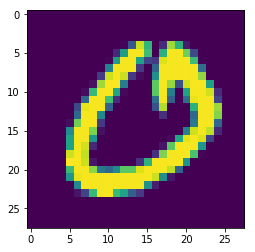

In [38]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

image = np.reshape(batch_x, (28,28))
plt.imshow(image)
#dog_image = train_dogs[200]
#dog_image = np.reshape(dog_image,(140,140,3))
#plt.imshow(dog_image)

In [7]:
dog_image

array([[[ 96,  99,  92],
        [ 98, 101,  94],
        [102, 105,  98],
        ..., 
        [ 23,   9,   8],
        [ 23,   9,   8],
        [ 23,   9,   8]],

       [[ 96,  99,  92],
        [ 99, 102,  95],
        [102, 105,  98],
        ..., 
        [ 23,   9,   8],
        [ 23,   9,   8],
        [ 23,   9,   8]],

       [[ 97, 100,  93],
        [100, 103,  96],
        [103, 106,  99],
        ..., 
        [ 23,   9,   8],
        [ 23,   9,   8],
        [ 23,   9,   8]],

       ..., 
       [[ 70,  28,  16],
        [ 72,  29,  20],
        [ 73,  30,  21],
        ..., 
        [ 19,   5,   2],
        [ 17,   3,   2],
        [ 21,   7,   6]],

       [[ 66,  24,  12],
        [ 69,  27,  15],
        [ 71,  29,  17],
        ..., 
        [ 21,   6,   3],
        [ 18,   4,   3],
        [ 20,   6,   5]],

       [[ 66,  22,   9],
        [ 69,  25,  12],
        [ 72,  28,  17],
        ..., 
        [ 20,   7,   1],
        [ 18,   4,   1],
        [ 18,   7,

In [40]:
pred = sess.run(output[0], feed_dict={Input[0]: batch_x})
#pred = sess.run(output[0], feed_dict={Input[0]: np.reshape(train_dogs[1], (1, 140*140*3))})
#pred = sess.run(Input[0], feed_dict={Input[0]: np.reshape(train_dogs[1], (1, 140*140*3))})

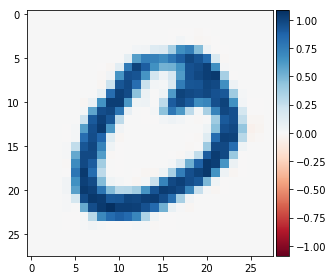

In [42]:
io.imshow(np.reshape(pred,(28,28)))

#plt.imshow(np.reshape(pred,(140,140,3)))

In [10]:
np.reshape(pred,(140,140,3))

array([[[ 75.44199371,  72.7962265 ,  52.44760513],
        [ 75.44199371,  72.7962265 ,  52.44760513],
        [ 75.44199371,  72.7962265 ,  52.44760513],
        ..., 
        [ 75.44199371,  72.7962265 ,  52.44760513],
        [ 75.44199371,  72.7962265 ,  52.44760513],
        [ 75.44199371,  72.7962265 ,  52.44760513]],

       [[ 75.44199371,  72.7962265 ,  52.44760513],
        [ 75.44199371,  72.7962265 ,  52.44760513],
        [ 75.44199371,  72.7962265 ,  52.44760513],
        ..., 
        [ 75.44199371,  72.7962265 ,  52.44760513],
        [ 75.44199371,  72.7962265 ,  52.44760513],
        [ 75.44199371,  72.7962265 ,  52.44760513]],

       [[ 75.44199371,  72.7962265 ,  52.44760513],
        [ 75.44199371,  72.7962265 ,  52.44760513],
        [ 75.44199371,  72.7962265 ,  52.44760513],
        ..., 
        [ 75.44199371,  72.7962265 ,  52.44760513],
        [ 75.44199371,  72.7962265 ,  52.44760513],
        [ 75.44199371,  72.7962265 ,  52.44760513]],

       ..., 
   

In [25]:
Input[0]

<tf.Tensor 'Placeholder:0' shape=(?, 784) dtype=float32>

In [ ]:
    # Testing
    # Encode and decode images from test set and visualize their reconstruction.
    n = 4
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    for i in range(n):
        # MNIST test set
        batch_x, _ = mnist.test.next_batch(n)
        # Encode and decode the digit image
        g = sess.run(decoder_op, feed_dict={X: batch_x})

        # Display original images
        for j in range(n):
            # Draw the original digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                batch_x[j].reshape([28, 28])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digits
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                g[j].reshape([28, 28])

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    
    plt.show()

In [1]:
""" Auto Encoder Example.
Build a 2 layers auto-encoder with TensorFlow to compress images to a
lower latent space and then reconstruct them.
References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""
from __future__ import division, print_function, absolute_import
import pdb
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib import slim

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = 256

display_step = 5000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers

hidden_dim=[256]
latent_dim= 30

d = 1
s = 28
s2, s4, s8 = int(np.ceil(s/2)), int(np.ceil(s/4)), int(np.ceil(s/8))

# Building the encoder
def encoder(x, hidden_dim, latent_dim, npix_x=28, npix_y = 28):
    
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.elu,
                      normalizer_fn=slim.batch_norm,
                      normalizer_params={'scale': True}):
        net = tf.reshape(x, [-1, 28, 28, 1])
        net = slim.conv2d(net, 32, 5, stride=2)
        net = slim.conv2d(net, 64, 5, stride=2)
        net = slim.conv2d(net, 128, 5, padding='VALID')
        net = slim.dropout(net, 0.9)
        net = slim.flatten(net)
        #net = slim.fully_connected(net, 100)


        return net


# Building the decoder
def decoder(z, hidden_dim, input_dim):
    with slim.arg_scope([slim.conv2d_transpose],
                      activation_fn=tf.nn.elu,
                      normalizer_fn=slim.batch_norm,
                      normalizer_params={'scale': True}):
        
        net = tf.reshape(z, [-1, 1, 1, d])
        net = slim.conv2d_transpose(net, 128, 3, padding='VALID')
        net = slim.conv2d_transpose(net, 64, 5, padding='VALID')
        net = slim.conv2d_transpose(net, 32, 5, stride=2)
        net = slim.conv2d_transpose(net, 1, 5, stride=2, activation_fn=None)
        net = slim.flatten(net)
        return net


# Construct model
with tf.variable_scope('encoder'):
    encoder_op = encoder(X, hidden_dim, latent_dim)
with tf.variable_scope('decoder'):
    decoder_op = decoder(encoder_op, hidden_dim, latent_dim)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start Training
saver = tf.train.Saver(max_to_keep=50)
# Start a new TF session
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)

        # Run optimization op (backprop) and cost op (to get loss value)
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))
            save_path = saver.save(sess, "./"+ "saved" + "/Iter" + str(i)  + ".ckpt")


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


NotFoundError: No algorithm without scratch worked!
	 [[Node: decoder/Conv2d_transpose_1/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](decoder/Conv2d_transpose_1/stack, decoder/Conv2d_transpose_1/weights/read, decoder/Conv2d_transpose/Elu)]]
	 [[Node: Mean/_161 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2653_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'decoder/Conv2d_transpose_1/conv2d_transpose', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-af31bac43bf8>", line 90, in <module>
    decoder_op = decoder(encoder_op, hidden_dim, latent_dim)
  File "<ipython-input-1-af31bac43bf8>", line 79, in decoder
    net = slim.conv2d_transpose(net, 64, 5, padding='VALID')
  File "/home/nicolas/py3_tensorflow_1.3/local/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "/home/nicolas/py3_tensorflow_1.3/local/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1246, in convolution2d_transpose
    outputs = layer.apply(inputs)
  File "/home/nicolas/py3_tensorflow_1.3/local/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 503, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/nicolas/py3_tensorflow_1.3/local/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 450, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/nicolas/py3_tensorflow_1.3/local/lib/python3.5/site-packages/tensorflow/python/layers/convolutional.py", line 1162, in call
    data_format=utils.convert_data_format(self.data_format, ndim=4))
  File "/home/nicolas/py3_tensorflow_1.3/local/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 1048, in conv2d_transpose
    name=name)
  File "/home/nicolas/py3_tensorflow_1.3/local/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 486, in conv2d_backprop_input
    data_format=data_format, name=name)
  File "/home/nicolas/py3_tensorflow_1.3/local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/nicolas/py3_tensorflow_1.3/local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/nicolas/py3_tensorflow_1.3/local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): No algorithm without scratch worked!
	 [[Node: decoder/Conv2d_transpose_1/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](decoder/Conv2d_transpose_1/stack, decoder/Conv2d_transpose_1/weights/read, decoder/Conv2d_transpose/Elu)]]
	 [[Node: Mean/_161 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2653_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [1]:
from tensorflow.contrib import slim as slim